In [2]:
import h5py

# Path to your HDF5 file
file_path = "/Users/sikongqian/program/209project/MoDL_PyTorch/data/dataset.hdf5"

# Open the file in read mode
with h5py.File(file_path, "r") as hdf:
    # List all groups and datasets in the file
    def print_structure(name, obj):
        print(name)

    print("HDF5 file structure:")
    hdf.visititems(print_structure)

    # Access specific groups or datasets
    for key in hdf.keys():
        print(f"Key: {key}")
        print(f"Shape: {hdf[key].shape}")
        print(f"Data type: {hdf[key].dtype}")
        #print("Preview:", hdf[key][:5])  # Show the first 5 entries


HDF5 file structure:
trnCsm
trnMask
trnOrg
tstCsm
tstMask
tstOrg
Key: trnCsm
Shape: (360, 12, 256, 232)
Data type: complex64
Key: trnMask
Shape: (360, 256, 232)
Data type: int8
Key: trnOrg
Shape: (360, 256, 232)
Data type: complex64
Key: tstCsm
Shape: (164, 12, 256, 232)
Data type: complex64
Key: tstMask
Shape: (164, 256, 232)
Data type: int8
Key: tstOrg
Shape: (164, 256, 232)
Data type: complex64


HDF5 file structure:
trnMask
trnOrg
tstMask
tstOrg
Key: trnMask
Shape: (360, 256, 232)
Data type: int8
Key: trnOrg
Shape: (360, 256, 232)
Data type: complex64
Key: tstMask
Shape: (164, 256, 232)
Data type: int8
Key: tstOrg
Shape: (164, 256, 232)
Data type: complex64

I want to use our fully sampled image and under sampled data try to test out model
I have data in this struture
ground_truth_images
    .tiff images

here I have data in HDF5 file
HDF5 file structure:
trnMask
trnOrg
tstMask
tstOrg 
Key: trnMask 3d
Data type: int8
Key: trnOrg 3d
Data type: complex64
Key: tstMask 3d
Data type: int8
Key: tstOrg 3d
Data type: complex64

I want to replace tstOrg and trnOrg use ground_truth_images
and replace mask using following code

def create_random_mask(height, width, center_fraction=0.1, undersample_fraction=0.5, seed=50):
    """
    Create a 2D random mask with a fully sampled center region.

    Args:
        height: The height of the mask (frequency encoding dimension).
        width: The width of the mask (phase encoding dimension).
        center_fraction: Fraction of the image to be fully sampled at the center.
        undersample_fraction: Fraction of the remaining k-space to be sampled randomly.

    Returns:
        mask_2d: A binary mask with the same shape as the k-space data.
    """
    if seed is not None:
        np.random.seed(seed)  # Set the random seed locally
        mask = np.zeros((height, width))
    
    # Fully sample the center region
    center_height = int(height * center_fraction)
    center_width = int(width * center_fraction)
    center_start_h = (height - center_height) // 2
    center_start_w = (width - center_width) // 2
    mask[center_start_h:center_start_h + center_height, center_start_w:center_start_w + center_width] = 1
    
    # Randomly sample the remaining k-space
    remaining_mask = np.random.choice([0, 1], size=(height, width), p=[undersample_fraction, 1-undersample_fraction])
    mask = np.maximum(mask, remaining_mask)  # Ensure the center is fully sampled
    
    return mask

finally I want to have 3.hdf5 file, has undersample rate 0.1, 0.5 and 0.7 corresponding
please write a code help me

### **Datasets**

#### 1. **`trnCsm` and `tstCsm`**
   - **Shape:** `(number_of_samples, n_coils, n_rows, n_cols)`
   - **Data Type:** `complex64`
   - **Description:**
     - These are **coil sensitivity maps** (CSMs), which are used in parallel Magnetic Resonance Imaging (MRI) to combine the data from multiple receiver coils into a single image.
     - Each entry represents the spatial sensitivity of a coil in a complex format (real + imaginary parts).
     - **Purpose:** Helps to reconstruct fully sampled images from undersampled k-space data in multi-coil MRI systems.

---

#### 2. **`trnMask` and `tstMask`**
   - **Shape:** `(number_of_samples, n_rows, n_cols)`
   - **Data Type:** `int8`
   - **Description:**
     - These are **sampling masks**, often used to simulate undersampling in k-space (the frequency domain of MRI data).
     - Each value is either `1` (sampled) or `0` (not sampled).
     - **Purpose:** Determines which parts of the k-space data are retained during undersampling.

---

#### 3. **`trnOrg` and `tstOrg`**
   - **Shape:** `(number_of_samples, n_rows, n_cols)`
   - **Data Type:** `complex64`
   - **Description:**
     - These are the **ground truth fully sampled images** in the image domain, represented as complex numbers.
     - They are the "original" images obtained from fully sampled k-space data.
     - **Purpose:** Serves as the reference (target) images for training and testing the reconstruction algorithms.

---

### **Dataset Naming Conventions**
   - **`trn` and `tst`:**
     - `trn`: Training data.
     - `tst`: Testing data.
   - Each prefix indicates the dataset is part of the training (`trn`) or testing (`tst`) phase of the pipeline.

---

### **Workflow Context**
In the context of an MRI reconstruction project (like the MoDL-based project you are working on), these datasets are used as follows:

1. **Input:**
   - Use `trnCsm` and `trnMask` (or `tstCsm` and `tstMask`) to simulate undersampled k-space data.
   - The combination of the CSMs, the sampling mask, and the original image (`trnOrg` or `tstOrg`) allows the model to simulate the MRI acquisition process.

2. **Model Target:**
   - The `trnOrg` (or `tstOrg`) dataset serves as the target for the model to learn from or compare against during training or evaluation.

3. **Testing:**
   - Use `tstCsm`, `tstMask`, and `tstOrg` to validate the model's ability to reconstruct high-quality images from undersampled data.

---

### **Summary**
- **`Csm`**: Coil sensitivity maps for multi-coil MRI.
- **`Mask`**: Sampling patterns for undersampling in k-space.
- **`Org`**: Ground truth fully sampled images.
- The datasets are divided into training (`trn`) and testing (`tst`) sets.

These datasets enable training, testing, and validating models designed for MRI image reconstruction.

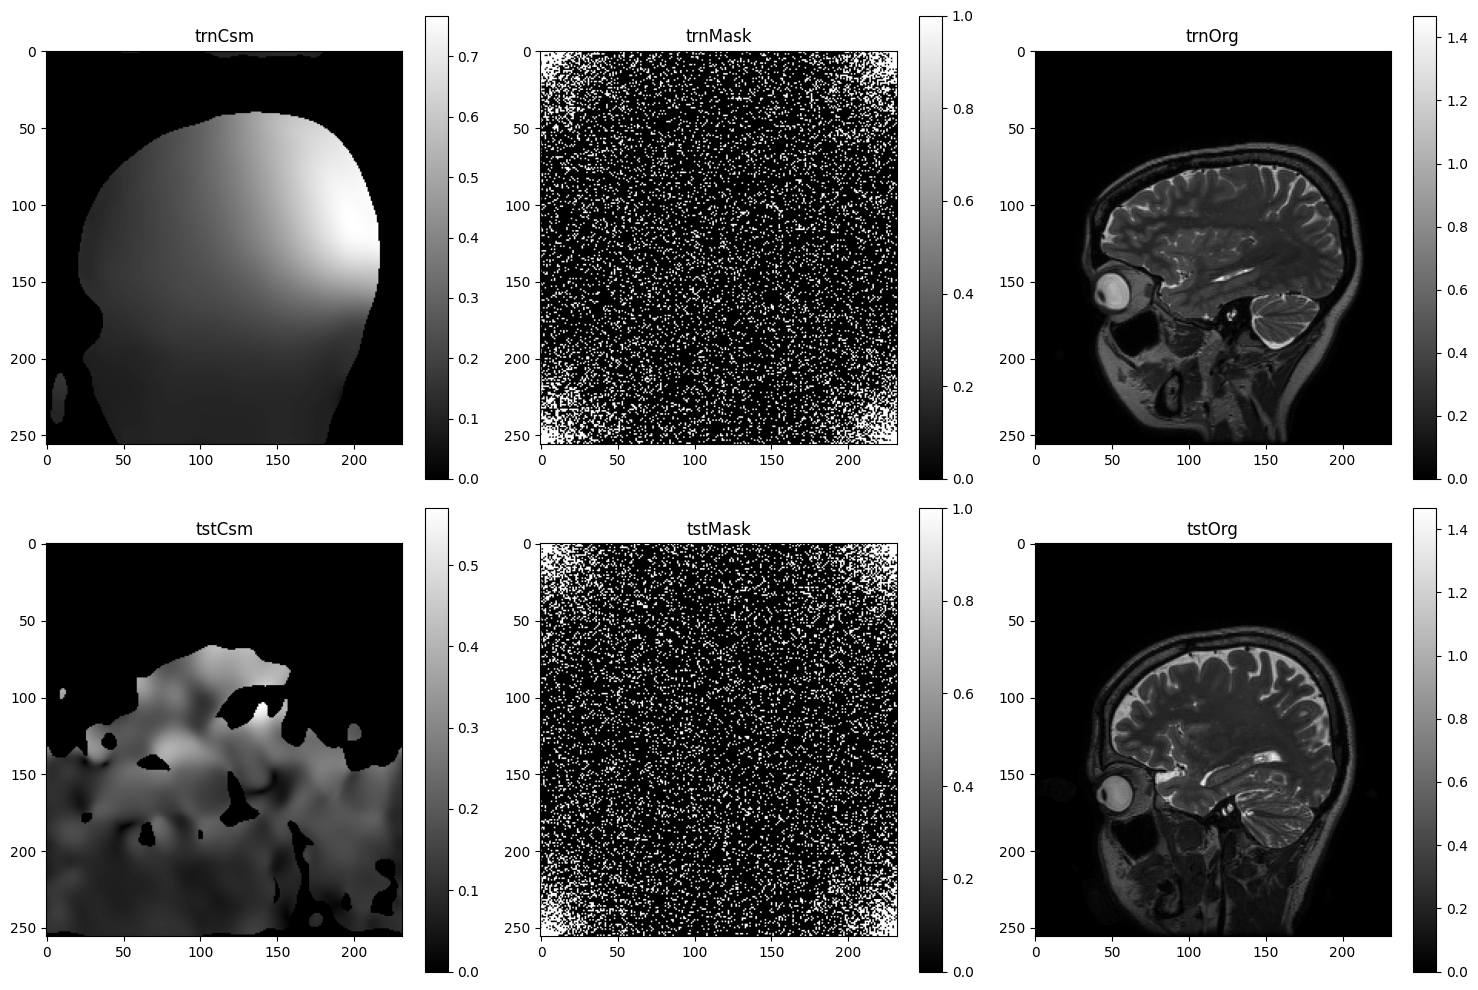

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the HDF5 file
file_path = "/Users/sikongqian/program/209project/MoDL_PyTorch/data/dataset.hdf5"  # Replace with your file path
with h5py.File(file_path, 'r') as f:
    # Extract all keys and data
    datasets = {key: f[key][:] for key in f.keys()}

# Set up the plot grid (2 rows x 3 columns for the 6 keys)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # Flatten the grid into a 1D array

# Iterate through each dataset
for i, (name, data) in enumerate(datasets.items()):
    ax = axes[i]  # Get the subplot for this dataset
    
    # Handle complex data by taking the magnitude
    if np.iscomplexobj(data):
        if len(data.shape) == 4:  # For datasets like `trnCsm` and `tstCsm`
            slice_data = np.abs(data[0, 0, :, :])  # Select the first slice and channel
            
        elif len(data.shape) == 3:  # For datasets like `trnOrg` and `tstOrg`
            slice_data = np.abs(data[50, :, :])  # Select the first slice
    else:
        slice_data = data[0, :, :]  # For `trnMask` and `tstMask`
      

    # Plot the data
    im = ax.imshow(slice_data, cmap='gray')
    ax.set_title(name)
    plt.colorbar(im, ax=ax)

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()


In [35]:
import h5py
import numpy as np
from PIL import Image
import glob
import os

# Function to create a random mask
def create_random_mask(height, width, center_fraction=0.2, undersample_fraction=0.0, seed=50):
    np.random.seed(seed)  # Set random seed for reproducibility
    mask = np.zeros((height, width))
    
    # Fully sample the center region
    center_height = int(height * center_fraction)
    center_width = int(width * center_fraction)
    center_start_h = (height - center_height) // 2
    center_start_w = (width - center_width) // 2
    mask[center_start_h:center_start_h + center_height, center_start_w:center_start_w + center_width] = 1
    
    # Randomly sample the remaining k-space
    remaining_mask = np.random.choice([1, 0], size=(height, width), p=[undersample_fraction, 1 - undersample_fraction])
    mask = np.maximum(mask, remaining_mask)  # Ensure center is fully sampled
    
    return mask

# Replace tstOrg and trnOrg, and save undersampled data
def process_hdf5(input_hdf5_path, ground_truth_path, output_dir):
    # Read ground truth images and filter by resolution
    ground_truth_files = sorted(glob.glob(os.path.join(ground_truth_path, "*.tiff")))
    filtered_images = []
    for file in ground_truth_files:
        img = Image.open(file)
        print(img.size)
        if img.size == (320, 640):  # Filter for images with size 640x320
            filtered_images.append(np.array(img).astype(np.complex64))
    
    # Open the original HDF5 file
    with h5py.File(input_hdf5_path, 'r') as input_hdf5:
        trnOrg_shape = input_hdf5['trnOrg'].shape
        tstOrg_shape = input_hdf5['tstOrg'].shape

    # Validate that filtered images are sufficient
    assert len(filtered_images) >= trnOrg_shape[0] + tstOrg_shape[0], "Not enough 640x320 images in ground_truth_images"

    # Stack the filtered images
    all_ground_truth = np.stack(filtered_images[:trnOrg_shape[0] + tstOrg_shape[0]], axis=0)

    # Split into trnOrg and tstOrg
    trnOrg_new = all_ground_truth[:trnOrg_shape[0]]
    tstOrg_new = all_ground_truth[trnOrg_shape[0]:]

    # Create output HDF5 files for each undersampling rate
    undersample_rates = [0.0,0.1, 0.25, 0.5, 1]
    for rate in undersample_rates:
        output_hdf5_path = os.path.join(output_dir, f"undersampled_{int(rate * 100)}.hdf5")
        with h5py.File(output_hdf5_path, 'w') as output_hdf5:
            # Create random masks
            trnMask_new = np.array([create_random_mask(640, 320, undersample_fraction=rate) for _ in range(trnOrg_shape[0])])
            tstMask_new = np.array([create_random_mask(640, 320, undersample_fraction=rate) for _ in range(tstOrg_shape[0])])
            
            # Write new datasets
            output_hdf5.create_dataset('trnMask', data=trnMask_new.astype(np.int8))
            output_hdf5.create_dataset('tstMask', data=tstMask_new.astype(np.int8))
            output_hdf5.create_dataset('trnOrg', data=trnOrg_new)
            output_hdf5.create_dataset('tstOrg', data=tstOrg_new)
        
        print(f"Created undersampled HDF5 file: {output_hdf5_path}")

# Paths to data
input_hdf5_path = "data/dataset.hdf5"  # Replace with your input HDF5 file path
ground_truth_path = "/Users/sikongqian/program/209project/data/ground_truth_images"  # Replace with the directory containing .tiff images
output_dir = "data"  # Replace with desired output directory

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process the HDF5 file
process_hdf5(input_hdf5_path, ground_truth_path, output_dir)


(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(320, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(214, 512)
(214, 512)
(214, 512)
(214, 512)
(214, 512)
(214, 512)
(214, 512)
(214, 512)
(214, 512)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)
(264, 640)

what we want to do is?
using the saved model do forward pass
compare the difference and residual of undersample image, recon image and fully sample image
model saved at /Users/sikongqian/program/209project/MoDL_PyTorch/workspace/base_modl,k=10/checkpoints/final.epoch0049-score39.6311.pth
I need to understand what is the input of the model, what the output

understand CG algorithm, does csm influence the process? use mask.


(640, 320)
(640, 320)
x0: type= <class 'numpy.ndarray'> shape= (640, 320) dtype= complex128
x0: type= <class 'numpy.ndarray'> shape= (640, 320) dtype= float64
<class 'numpy.float64'>


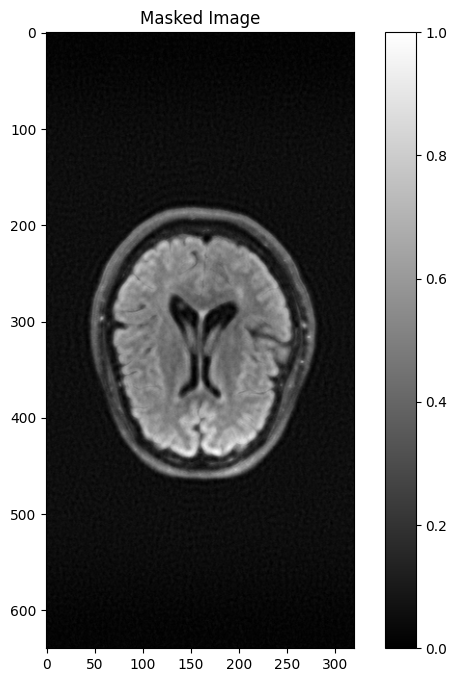

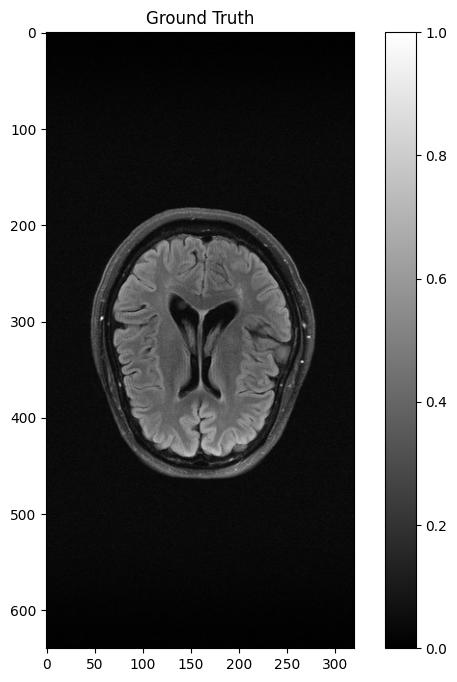

25.060444090595418
0.803199977843242


In [ ]:
# plot the image undersampled
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils import c2r
def undersample(gt, mask, sigma=0.01):
    """
    Perform undersampling without coil sensitivity maps (csm).
    
    Args:
        
        
        : Ground truth image (2D or 3D array).
        mask: Undersampling mask (same spatial dimensions as `gt`).
        sigma: Noise standard deviation (not used in this version).
    
    Returns:
        atb: Undersampled and noisy k-space data.
    """
    nrow, ncol = mask.shape
    sample_idx = np.where(mask.flatten() != 0)[0]
    noise = np.random.randn(len(sample_idx)) + 1j*np.random.randn(len(sample_idx))
    noise = noise * (sigma / np.sqrt(2.))
    # Forward model (undersample the Fourier transform of `gt`)
    
    # Compute the k-space (Fourier transform) of the ground truth image
    gt_fft = np.fft.fft2(gt)
    
    # Shift the zero-frequency component to the center
    gt_fft_shifted = np.fft.fftshift(gt_fft)

    # Create a new k-space array to store the undersampled k-space
    gt_fft_sampled = np.zeros_like(gt_fft_shifted, dtype=complex)

    # Apply the undersampling mask
    gt_fft_sampled[np.unravel_index(sample_idx, (nrow, ncol))] = gt_fft_shifted[np.unravel_index(sample_idx, (nrow, ncol))]+noise

    # Shift the zero-frequency component back to its original location before inverse FFT
    gt_fft_sampled_shifted_back = np.fft.ifftshift(gt_fft_sampled)

    # Inverse FFT to obtain the undersampled image
    atb = np.fft.ifft2(gt_fft_sampled_shifted_back)
    print(atb.shape)
    return atb

# Open the HDF5 dataset and extract data
with h5.File('/Users/sikongqian/program/209project/MoDL_PyTorch/data/undersampled_25.hdf5', 'r') as f:
    gt, mask = f['trn'+'Org'][20], f['trn'+'Mask'][20]
    print(gt.shape)

# Apply the undersample function
x0 = undersample(gt, mask, 0.01)
print("x0: type=", type(gt), "shape=", x0.shape, "dtype=", x0.dtype)

# Normalize the data to the range [0, 1] to avoid issues with visualization
x0 = np.abs(x0)
gt = np.abs(gt)
print("x0: type=", type(x0), "shape=", x0.shape, "dtype=", x0.dtype)

x0 = (x0 - np.min(x0)) / (np.max(x0) - np.min(x0))  # Avoid division by zero
gt = (gt - np.min(gt)) / (np.max(gt) - np.min(gt))  # Normalize ground truth
            

print(type(x0[1][1]))
#x0 = c2r(x0)[0]
#gt = c2r(gt)[0]
# Plot the masked image
plt.figure(figsize=(8, 8))
plt.imshow(x0, cmap='gray')  # Display the masked image in grayscale
plt.title('Masked Image')
plt.colorbar()  # Show the color bar to see the intensity scale
plt.show()

# Optionally, plot the ground truth (gt) for comparison
plt.figure(figsize=(8, 8))
plt.imshow(gt, cmap='gray')  # Display the ground truth image in grayscale
plt.title('Ground Truth')
plt.colorbar()  # Show the color bar to see the intensity scale
plt.show()

from utils import psnr
a = psnr(gt,x0)
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

psnr(gt,x0, data_range=gt.max() - gt.min())
print(a)
b = ssim(gt,x0, data_range=gt.max() - gt.min())
print(b)